In [1096]:
import pandas as pd
import json
import re
import statsmodels.regression.linear_model as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import chisquare
from sklearn.linear_model import RidgeCV
from sklearn.cross_validation import cross_val_score
from sklearn import feature_selection as f_select
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler



%matplotlib inline

In [1097]:
# Load movie data
with open('result10.json') as f:
    data = json.load(f)

with open('studios.txt') as f:
    studios = []
    for s in f:
        studios.append(s.strip())
        

In [1098]:
# Load inflation data
inf_index = pd.read_csv('inflation.csv', header=None)
inf_index.columns = ['year', 'inflation']
inf_index.year = inf_index.year.str.replace('[^\d]*', '').astype(int)
inf_index.inflation = inf_index.inflation.str\
                                            .replace('[^\w]*', '')\
                                            .astype(float)\
                                            .apply(lambda x: x/10000)

In [1099]:
# Load dataframe
df = pd.DataFrame(data)
df.drop(['download_latency', 'download_slot','download_timeout', 'depth'], axis=1, inplace=True)
df.columns.tolist()

['budget',
 'country',
 'director',
 'genre',
 'language',
 'lifetime',
 'mojo_url',
 'mpaa',
 'opening',
 'rating',
 'rating_count',
 'release',
 'runtime',
 'studio',
 'theaters',
 'title',
 'url',
 'worldwide',
 'year']

In [1100]:
# Replace None, nan, or n/a strings with np.nan
df = df.applymap(lambda x: np.nan if ((str(x).lower() == 'nan') or (str(x) == 'n/a') or (str(x) == 'None')) else x)

In [1101]:
df.shape

(3173, 19)

In [1102]:
df.mpaa.value_counts()

R        1466
PG-13    1215
PG        437
G          50
NC-17       4
PG-         1
Name: mpaa, dtype: int64

In [963]:
def convert_currency(key, year):
    pass

In [1069]:
def adjust_inflation(start_year, year):
    ci = 1
    for i in range(start_year, year + 1):
        ci *= (inf_index.loc[inf_index.year==i, 'inflation'].values + 1)
    return ci

In [1104]:
# Type conversions
df.rating = df.rating.astype(float)
df.runtime = df.runtime.astype(float)
df.year = df.year.astype(int)


df.opening = df.opening.str.replace(r'[^\d]', '').astype(float)
df.theaters = df.theaters.str.replace(r'[^\d]', '').astype(float)
df.lifetime = df.lifetime.str.replace(r'[^\d]', '').astype(float)
df.worldwide = df.worldwide.str.replace(r'[^\d]', '').astype(float)


# Datetime
df.release = pd.to_datetime(df.release, format='%Y-%m-%d')
df['month_cat'] = df.release.dt.strftime('%B')

# Currency Convert
df.budget = df.budget.str.replace(r'[^\d]', '').astype(float)

# Inflation adjusted columns
#df['opening_adjusted'] = df.opening
#df['']

# Log the money values
df['log_opening'] = np.log(df.opening)
df['log_lifetime'] = np.log(df.lifetime)
df['log_budget'] = np.log(df.budget)

# Log the money values
#df['log_opening_adjusted'] = np.log(df.opening_adjusted)
#df['log_lifetime_adjusted'] = np.log(df.lifetime_adjusted)
#df['log_budget_adjusted'] = np.log(df.budget_adjusted)



AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [1105]:
start_year = 2000
df['opening_adjusted'] = df.apply(lambda x: (x['opening'] * adjust_inflation(start_year, x['year'])), axis=1)['opening']

In [1106]:
# Genre
genre_pre = df.set_index('title').genre.str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('genre')
dummy_genre = pd.get_dummies(genre_pre, prefix='g', columns=['genre']).groupby(level=0).sum().reset_index()
col = dummy_genre.columns.str.replace(' ', '')
dummy_genre.columns = col

In [1107]:
# Language
df.language = df.language.str.replace(' ', '_')
language_pre = df.set_index('title').language.str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('language')
dummy_language = pd.get_dummies(language_pre, prefix='l', columns=['language']).groupby(level=0).sum().reset_index()

In [1108]:
# Month Dummy
df = pd.get_dummies(df, prefix='m', columns=['month_cat'])

In [1109]:
# Fix odd MPAA value
df.loc[df.mpaa =='PG-', 'mpaa'] = 'PG-13'
df.mpaa.value_counts()

R        1466
PG-13    1216
PG        437
G          50
NC-17       4
Name: mpaa, dtype: int64

In [1110]:
# MPAA
df = pd.get_dummies(df, prefix='m', columns=['mpaa'])

In [956]:
# Directors
#director_pre = df.set_index('title').director.str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('director')
#dummy_director = pd.get_dummies(director_pre, prefix='d', columns=['director']).groupby(level=0).sum().reset_index()

In [1111]:
# Country
df.country = df.country.str.replace(' ', '_')
country_pre = df.set_index('title').country.str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('country')
dummy_country = pd.get_dummies(country_pre, prefix='d', columns=['country']).groupby(level=0).sum().reset_index()

In [1112]:
# Merge all dummies
df_clean = df.merge(dummy_genre)
df_clean = df_clean.merge(dummy_language)
df_clean = df_clean.merge(dummy_country)
df_clean.shape

(3170, 210)

In [959]:
df_clean.columns.tolist()

['budget',
 'country',
 'director',
 'genre',
 'language',
 'lifetime',
 'mojo_url',
 'opening',
 'rating',
 'rating_count',
 'release',
 'runtime',
 'title',
 'url',
 'year',
 'log_opening',
 'log_lifetime',
 'log_budget',
 'm_April',
 'm_August',
 'm_December',
 'm_February',
 'm_January',
 'm_July',
 'm_June',
 'm_March',
 'm_May',
 'm_November',
 'm_October',
 'm_September',
 'm_G',
 'm_NC-17',
 'm_PG',
 'm_PG-13',
 'm_R',
 'g_Action',
 'g_Adventure',
 'g_Animation',
 'g_Biography',
 'g_Comedy',
 'g_Crime',
 'g_Drama',
 'g_Family',
 'g_Fantasy',
 'g_History',
 'g_Horror',
 'g_Music',
 'g_Musical',
 'g_Mystery',
 'g_Romance',
 'g_Sci-Fi',
 'g_Sport',
 'g_Thriller',
 'g_War',
 'g_Western',
 'l_',
 'l_Aboriginal',
 'l_Acholi',
 'l_Afrikaans',
 'l_Albanian',
 'l_Algonquin',
 'l_American_Sign_Language',
 'l_Amharic',
 'l_Apache_languages',
 'l_Arabic',
 'l_Aramaic',
 'l_Armenian',
 'l_Bambara',
 'l_Bengali',
 'l_Berber_languages',
 'l_Bosnian',
 'l_Bulgarian',
 'l_Burmese',
 'l_Cantones

In [688]:
# USD conversions
# Euro 
# Pound (check year conversion) grab year and exchange rate

# Do currency conversions


# clean budget

In [1113]:
df_clean.budget.head()

0    35000000.0
1      100000.0
2    12000000.0
3           NaN
4           NaN
Name: budget, dtype: float64

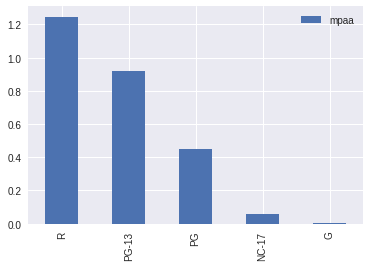

In [431]:
fig,ax = plt.subplots()
percent_15.plot(kind='bar', ax=ax)
percent_14.plot(kind='bar', ax=ax)

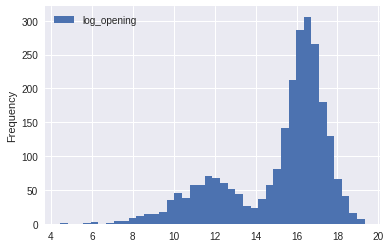

In [519]:
fig,ax = plt.subplots()
df_clean_dr.plot(kind='hist', y='log_opening', ax=ax, bins=40)

In [ ]:
fig,ax = plt.subplots()
df_clean_dropped.plot(kind='hist', y='log_opening', ax=ax, bins=40)

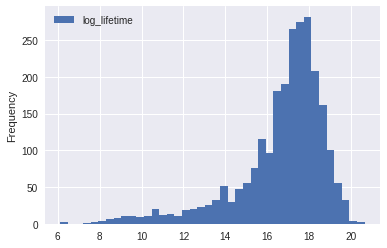

In [273]:
fig,ax = plt.subplots()
df_clean_dropped.plot(kind='hist', y='log_lifetime', ax=ax, bins=40)

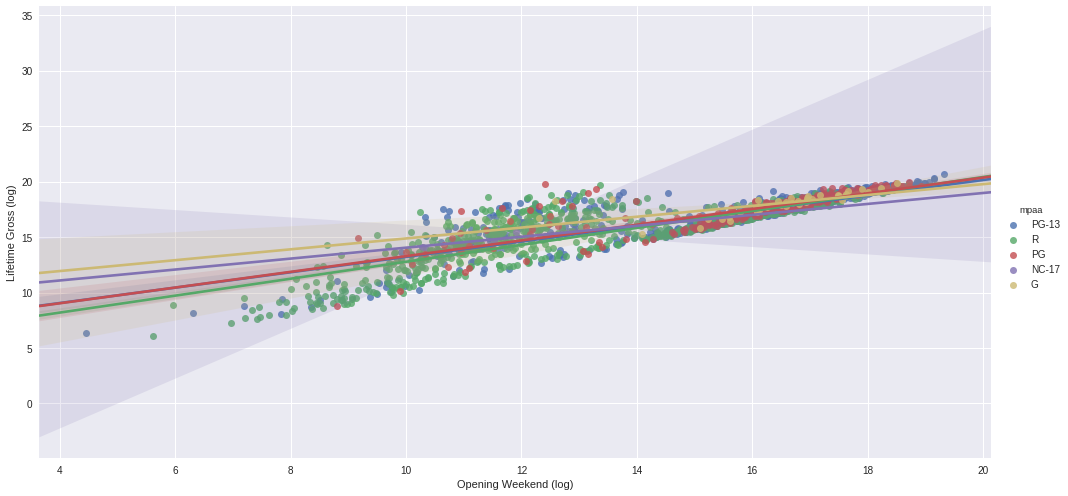

In [274]:
#fig, ax= plt.subplots(figsize=(12,5))
ax = sns.lmplot(x='log_opening', y='log_lifetime', hue='mpaa', data=df_clean_dropped, size=7, aspect=2)
ax.set_xlabels('Opening Weekend (log)')
ax.set_ylabels('Lifetime Gross (log)')


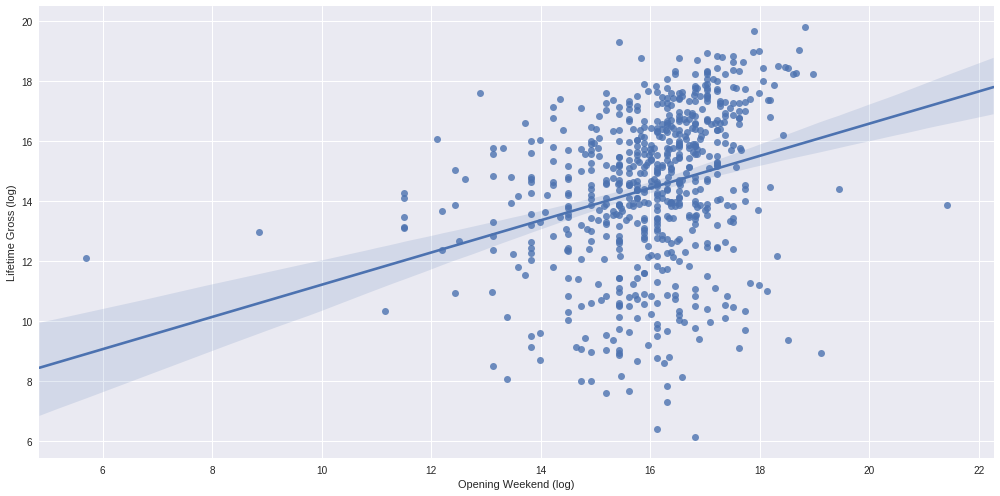

In [588]:
#fig, ax= plt.subplots(figsize=(12,5))
df_div1 = df_clean_dr[df_clean_dr.log_opening < 14]
ax = sns.lmplot(x='log_budget', y='log_lifetime', data=df_div1, size=7, aspect=2)
ax.set_xlabels('Opening Weekend (log)')
ax.set_ylabels('Lifetime Gross (log)')


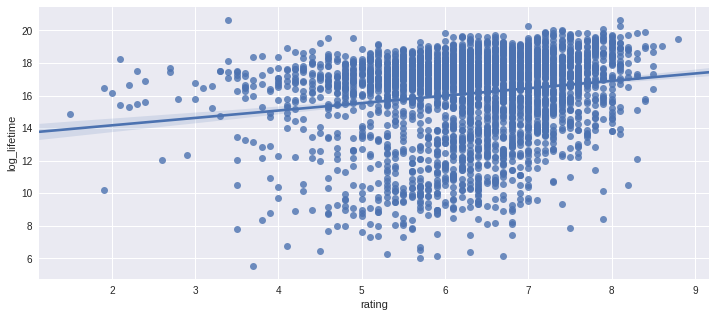

In [589]:
fig, ax= plt.subplots(figsize=(12,5))
sns.regplot(x='rating', y='log_lifetime', data=df_clean)

(1834, 209)

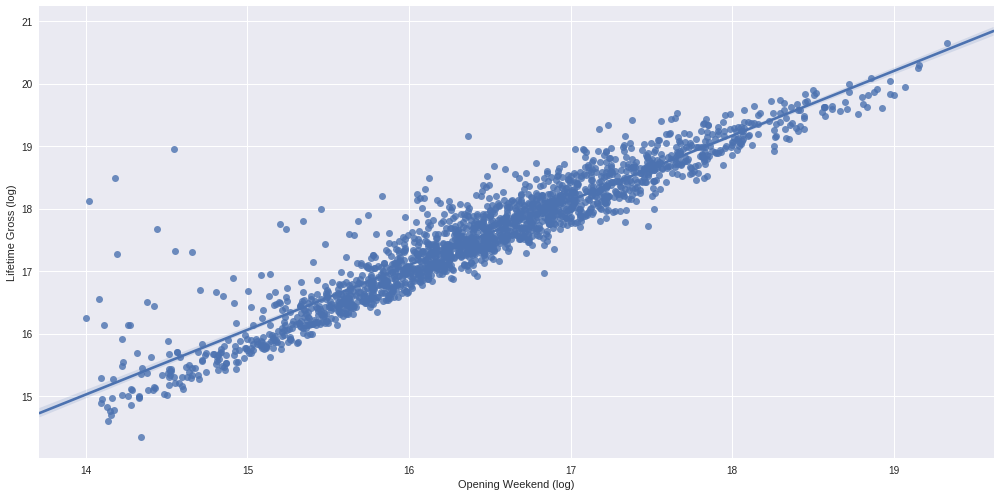

In [591]:
#fig, ax= plt.subplots(figsize=(12,5))
df_div1 = df_clean_dr[df_clean_dr.log_opening > 14]
ax = sns.lmplot(x='log_opening', y='log_lifetime', data=df_div1, size=7, aspect=2)
ax.set_xlabels('Opening Weekend (log)')
ax.set_ylabels('Lifetime Gross (log)')
ax.set_titles('Log-Log of Opening Weekend vs Lifetime Gross for Openings Greater than 1.2m USD')
df_div1.shape

In [962]:
def find_sig_cols(X, y, alpha=0.05):
    sig_cols = []
    for c in X.columns:
        pvalue = f_select.f_regression(X[[c]], y)[1][0]
        if pvalue <= alpha:
            sig_cols.append(c)

    return sig_cols

In [1115]:
non_model = ['genre', 'director', 
               'url', 'language', 
               'country', 'mojo_url',
              'rating_count','title', 
               'budget', 'opening', 
               'release']
others = ['log_opening', 'lifetime']
non_model.extend(others)

In [1117]:
df_mod = df_clean_dr.drop(non_model,axis=1)
sig_columns = find_sig_cols(df_mod.drop('log_lifetime', axis=1), df_mod.log_lifetime, alpha=0.05)

ValueError: labels ['log_opening'] not contained in axis

In [1119]:
est = make_pipeline(PolynomialFeatures(1),StandardScaler(), RidgeCV(cv=4))
X = df_mod.drop('log_lifetime', axis=1)#[sig_columns]
y = df_mod.log_lifetime

In [1128]:
# Auto CV test
est.fit(X, y)
est.score(X, y)
X.columns.tolist()

['rating',
 'runtime',
 'year',
 'log_budget',
 'm_April',
 'm_August',
 'm_December',
 'm_February',
 'm_January',
 'm_July',
 'm_June',
 'm_March',
 'm_May',
 'm_November',
 'm_October',
 'm_September',
 'm_G',
 'm_NC-17',
 'm_PG',
 'm_PG-13',
 'm_R',
 'g_Action',
 'g_Adventure',
 'g_Animation',
 'g_Biography',
 'g_Comedy',
 'g_Crime',
 'g_Drama',
 'g_Family',
 'g_Fantasy',
 'g_History',
 'g_Horror',
 'g_Music',
 'g_Musical',
 'g_Mystery',
 'g_Romance',
 'g_Sci-Fi',
 'g_Sport',
 'g_Thriller',
 'g_War',
 'g_Western',
 'l_',
 'l_Aboriginal',
 'l_Acholi',
 'l_Afrikaans',
 'l_Albanian',
 'l_Algonquin',
 'l_American_Sign_Language',
 'l_Amharic',
 'l_Apache_languages',
 'l_Arabic',
 'l_Aramaic',
 'l_Armenian',
 'l_Bambara',
 'l_Bengali',
 'l_Berber_languages',
 'l_Bosnian',
 'l_Bulgarian',
 'l_Burmese',
 'l_Cantonese',
 'l_Catalan',
 'l_Chechen',
 'l_Chinese',
 'l_Corsican',
 'l_Croatian',
 'l_Czech',
 'l_Danish',
 'l_Dari',
 'l_Dutch',
 'l_Egyptian_(Ancient)',
 'l_English',
 'l_Esperanto'

In [930]:
#model = sm.OLS(y, X.astype(float))
#fit = model.fit()
#fit.summary()

In [941]:
# Single fit test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
est.fit(X_train, y_train)
est.score(X_test, y_test)

-0.7546692375828884

In [932]:
# KFolds Cross-Validation
# Multiple Cross-Validation
for _ in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    est.fit(X_train, y_train)
    score.append(est.score(X_test, y_test, ))
sum(score)/len(score)



0.42243502284783707

In [1129]:
#coef_l = list(zip(X.columns, est.coef_.round(2)))
coef_l = list(zip(X.columns, est.steps[2][1].coef_))


In [1130]:
sorted(coef_l, key=lambda x: abs(x[1]), reverse=True)

[('m_April', 1.006398097309003),
 ('runtime', 0.50891680785643001),
 ('g_Family', -0.24663794388352298),
 ('g_Action', -0.22003131104845297),
 ('l_Chechen', -0.19180026166560563),
 ('g_Music', 0.18039454994976073),
 ('d_United_Arab_Emirates', 0.1613936519014717),
 ('g_Crime', 0.14833925963539185),
 ('d_Palestine', -0.14614551416934543),
 ('m_PG-13', 0.14542149867387288),
 ('year', 0.13410329370895346),
 ('d_Colombia', -0.12102010661800312),
 ('l_Georgian', 0.11641293851679671),
 ('g_Biography', -0.10908308021530339),
 ('d_USA', -0.10237992975031809),
 ('d_Germany', -0.099584942405153046),
 ('m_R', 0.098118412184073189),
 ('d_Indonesia', -0.097830689075728949),
 ('l_Catalan', -0.09461528014461032),
 ('l_Portuguese', -0.094379046742109257),
 ('l_', -0.088383638446827728),
 ('m_NC-17', 0.084610813868273224),
 ('g_Western', -0.083004608280625627),
 ('m_G', -0.08153066204740432),
 ('l_Nyanja', -0.080936177134549495),
 ('d_Spain', -0.080274298770814975),
 ('g_Fantasy', 0.079960976320955696),

In [39]:
# Cross validation
#scores = cross_val_score(est, X, y, cv=10, scoring='mean_squared_error', verbose=1)
#-scores

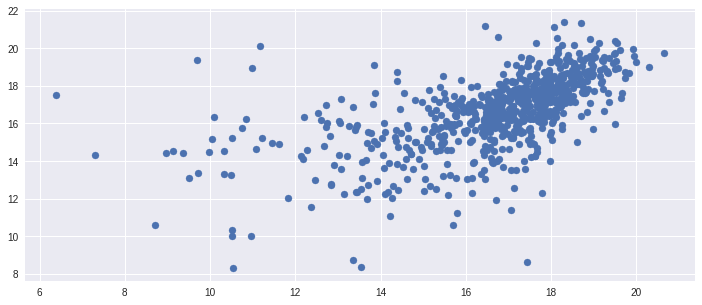

In [934]:
fig,ax = plt.subplots(figsize=(12,5))
ax.scatter(y_test, est.predict(X_test))

In [363]:
X_test.shape


#plot_compare(est, ax, X_test, y_test)
#fig

(815,)

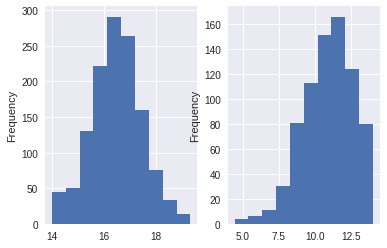

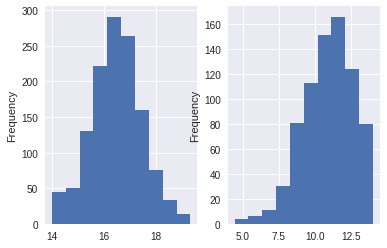

In [174]:
df_log1 = df_clean[(df_clean.log_opening > 14)]
df_log2 = df_clean[(df_clean.log_opening <= 14)]
fig, ax = plt.subplots(1,2)
df_log1.log_opening.plot(kind='hist', ax=ax[0])
df_log2.log_opening.plot(kind='hist', ax=ax[1])
fig

In [39]:
df_clustering = df_clean.drop(['l__Ancient_(to_1453)','lifetime','budget','director', 'genre', 'language', 'mpaa', 'url', 'rating_count', 'mojo_url', 'title', 'country'], axis=1)
df_clustering = df_clustering.dropna(how='any') 
cluster.k_means(df_clustering, 2).

(array([[  9.31354448e+06,   6.31060606e+00,   1.05814002e+02,
           2.01073406e+03,   2.03761755e-01,   1.49947753e-01,
           4.17972832e-02,   9.35214211e-02,   3.77220481e-01,
           1.87565308e-01,   5.71055381e-01,   9.50888192e-02,
           9.87460815e-02,   5.06792059e-02,   1.25391850e-01,
           4.02298851e-02,   1.56739812e-02,   1.20167189e-01,
           2.34587252e-01,   9.45663532e-02,   4.17972832e-02,
           3.24451411e-01,   3.50052247e-02,   1.25391850e-02,
           1.04493208e-03,   1.56739812e-03,   5.22466040e-04,
           3.65726228e-03,   1.56739812e-03,   5.22466040e-04,
           4.70219436e-03,   1.04493208e-03,   2.61233020e-02,
           1.04493208e-03,   2.08986416e-03,   0.00000000e+00,
           5.22466040e-04,   5.22466040e-04,   1.56739812e-03,
           5.22466040e-04,   1.20167189e-02,   5.22466040e-04,
           8.88192268e-03,   1.04493208e-03,   2.08986416e-03,
           3.65726228e-03,   1.56739812e-03,   1.567398

In [425]:
# Temporary, need to do currency conversions, or scrap from box office mojo
#df_clean.budget = df_clean.opening.str.replace('$', '')
#df_clean.budget = df_clean.opening.apply(lambda x: x if x.isdigit() else np.nan)
df_clean.budget[:5]

0     $20000000
1    $250000000
2      $6500000
3    $110000000
4    $108000000
Name: budget, dtype: object

In [426]:
# df_clean[df_clean.budget.apply(lambda x: str(x)[0]) != '$'].sort_values(by='budget')

In [427]:
#df_clean['currency'] = df_clean.budget.apply(lambda x: re.search(r'([^\d]+)([^(\s]+)', str(x))[1].strip() if (x is not np.nan) else np.nan)